[colab](https://colab.research.google.com/github/rufous86/studies/blob/main/DLS_NLP/05_language_modeling/hw_language_modelling.ipynb)

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы. 

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [4]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.5 MB/s eta 0:00:00


Импорт необходимых библиотек

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords

from collections import Counter
from typing import List

import string


import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['lines.linewidth'] = 1

import time

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [8]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [10]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence) if len(x) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [11]:
print("Всего предложений:", len(sentences))

Всего предложений: 28827


Посчитаем для каждого слова его встречаемость.

In [12]:
def count_words(dataset, remove_stops=False):
    words = Counter()
    if remove_stops:
        stops = stopwords.words('english')
    else:
        stops = []

    # Расчет встречаемости слов
    for example in tqdm(dataset):
        # Приводим к нижнему регистру и убираем пунктуацию
        processed_text = example.lower().translate(
            str.maketrans('', '', string.punctuation))
        processed_text = [
            word for word in word_tokenize(processed_text)
        ]

        for word in processed_text:
            words[word] += 1
    return words

words = count_words(dataset['train']['text'], remove_stops=False)

  0%|          | 0/25000 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [13]:
vocab_size = 40000

vocab = set(dict(sorted(words.items(), key=lambda x: x[1], reverse=True)[:vocab_size]).keys())
for serv_word in ['<unk>', '<bos>', '<eos>', '<pad>']:
    vocab.add(serv_word)

In [14]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [15]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [16]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [17]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        # Допишите код здесь
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx].split(' ')]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [18]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [19]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [20]:
def evaluate(model, criterion, dataloader) -> tuple[float, float]:
    model.eval()
    perplexity = []
    losses = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f'Validation'):
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1)) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten()).cpu().detach()
            perplexity.append(torch.exp(loss).item())
            losses.append(loss)
    
    perplexity = sum(perplexity) / len(perplexity)
    loss = sum(losses) / len(losses)

    return perplexity, loss.item()

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [21]:
def train_model(model, 
                train_dataloader, 
                val_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                algo_desc) -> dict:
    # Напишите код здесь
    start = time.time()
    losses = []
    perplexities = []
    val_losses = []
    val_perplexities = []

    for epoch in range(num_epoch):
        epoch_losses = []
        epoch_perplexities = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].flatten(start_dim=0, end_dim=1))
            loss = criterion(
                logits, batch['target_ids'].flatten())
            
            perplexity = torch.exp(loss).item()
            epoch_perplexities.append(perplexity)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(sum(epoch_perplexities) / len(epoch_perplexities))
        print('train_loss:', losses[-1])
        print('train_perplexity:', perplexities[-1])
            
        val_perplexity, val_loss = evaluate(model, criterion, val_dataloader)
        val_losses.append(val_loss)
        val_perplexities.append(val_perplexity)
        
        print('val_loss:', val_losses[-1])
        print('val_perplexity:', val_perplexities[-1])

    history = {
        'algo_desc': algo_desc,
        'train_loss': losses,
        'train_perplexity': perplexities,
        'val_loss': val_losses,
        'val_perplexity': val_perplexities,
        'execution_time': (time.time() - start) / num_epoch
        }
    return history

all_histories = []

Функция для вывода графиков

In [22]:
def plot_result(history):
    print(history['algo_desc'])
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'][1:], c='r', label='train')
    plt.plot(history['val_loss'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'loss, best on val {min(history["val_loss"]):.5f}')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_perplexity'][1:], c='r', label='train')
    plt.plot(history['val_perplexity'][1:], c='b', label='val')
    plt.legend()
    plt.title(f'perplexity, best on val {min(history["val_perplexity"]):.5f}')
    
    plt.show()

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

In [23]:
class LanguageModelLinear(nn.Module):
    def __init__(
        self, embed_dim: int, 
        hidden_dim: int, 
        vocab_size: int,
        num_layers: int,
        gru_is_bidirectional: bool):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.GRU(embed_dim, 
                          hidden_dim, 
                          num_layers, 
                          bidirectional=gru_is_bidirectional,
                          batch_first=True)
        
        if gru_is_bidirectional:
            self.linear = nn.Linear(hidden_dim*2, hidden_dim)
        else:
            self.linear = nn.Linear(hidden_dim, hidden_dim)

        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        x, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim] 
        x = self.dropout(self.linear(self.non_lin(x)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(x))  # [batch_size, num_classes]

        return prediction

In [24]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=1,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history1 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с 1 GRU слоем')

all_histories.append(history1)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 4.029228618790431
train_perplexity: 738.5158802791195


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.4869258403778076
val_perplexity: 32.99163360933287


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.373361994548397
train_perplexity: 29.39538307611455


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.246114492416382
val_perplexity: 25.926933204178262


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.1852654699462555
train_perplexity: 24.32728536616373


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.108431100845337
val_perplexity: 22.58024985389372


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.062865706438518
train_perplexity: 21.511321357600597


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.0154080390930176
val_perplexity: 20.566345695900708


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.9672467537347784
train_perplexity: 19.538310862377863


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9503581523895264
val_perplexity: 19.267962059088514


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.8885754682741114
train_perplexity: 18.053297959638563


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.894120693206787
val_perplexity: 18.209165184898715


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.8174006306664063
train_perplexity: 16.80814101814565


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.843475818634033
val_perplexity: 17.30487436952844


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.75225858266841
train_perplexity: 15.747544625846063


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.799626111984253
val_perplexity: 16.560820275703364


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.686760026447022
train_perplexity: 14.747234481474313


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.754251718521118
val_perplexity: 15.824696920614327


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.6229175362139117
train_perplexity: 13.834560468051974


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.7334256172180176
val_perplexity: 15.506683467763715


Попробуем увеличить количество GRU слоев

In [25]:
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history2 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с 2 GRU слоями')

all_histories.append(history2)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 4.098655753372783
train_perplexity: 703.9007200167324


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.593740463256836
val_perplexity: 36.70646031134952


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.5482101124294556
train_perplexity: 35.006243236815735


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.4694900512695312
val_perplexity: 32.39708397451755


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.385358753783927
train_perplexity: 29.73659231913024


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.2694623470306396
val_perplexity: 26.52172593310871


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.2187613795475407
train_perplexity: 25.158151236686916


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.1309189796447754
val_perplexity: 23.08637880646022


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.0876972069397817
train_perplexity: 22.054756238315644


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 3.0281105041503906
val_perplexity: 20.821581325699796


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.981755348858912
train_perplexity: 19.824465962404705


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9612691402435303
val_perplexity: 19.46357443480365


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.8926909272841987
train_perplexity: 18.127378569123493


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.9091036319732666
val_perplexity: 18.476609787054823


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.81432431047134
train_perplexity: 16.754147097550703


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.853654384613037
val_perplexity: 17.486316140774075


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.739346190710753
train_perplexity: 15.538734868086504


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.814488172531128
val_perplexity: 16.81810238087072


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.671745874605126
train_perplexity: 14.516858917573538


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.787217617034912
val_perplexity: 16.37084342315134


Попробуем Bidirectional GRU

In [26]:
# Обучите модель здесь
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=1,
                            gru_is_bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history3 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с Bidirectional GRU слоем')

all_histories.append(history3)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.5177660212332373
train_perplexity: 559.4999447395788


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.513751268386841
val_perplexity: 12.467800528602263


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.09278526556426
train_perplexity: 8.398525314436434


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.5984230041503906
val_perplexity: 4.981494390859013


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.3485290059068584
train_perplexity: 3.927300467675562


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.0030927658081055
val_perplexity: 2.7427944166470417


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.8785955500866168
train_perplexity: 2.4299416917463694


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.6751301884651184
val_perplexity: 1.9733309893481499


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.6025423033790693
train_perplexity: 1.8360574653794093


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.4794754385948181
val_perplexity: 1.620783490417278


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.42365679787008803
train_perplexity: 1.5320495307774833


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.35914358496665955
val_perplexity: 1.4359486039760894


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.2996365855247276
train_perplexity: 1.351776667062749


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.2734983265399933
val_perplexity: 1.3175343380565137


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.20975243650088654
train_perplexity: 1.2346509003507498


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.21655745804309845
val_perplexity: 1.244379799977868


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.1388944130576118
train_perplexity: 1.1496427197482704


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.17360612750053406
val_perplexity: 1.1918811660952273


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.08450172845665263
train_perplexity: 1.088435065021831


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.13881056010723114
val_perplexity: 1.1509674228398146


Попробуем 2 слоя Bidirectional GRU

In [27]:
model = LanguageModelLinear(embed_dim=256, 
                            hidden_dim=256, 
                            vocab_size=len(vocab),
                            num_layers=2,
                            gru_is_bidirectional=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history4 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Linear с 2 Bidirectional GRU слоями')

all_histories.append(history4)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 3.521787877899507
train_perplexity: 523.3113807551769


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.6340134143829346
val_perplexity: 14.062409865117706


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.4247449866974553
train_perplexity: 11.460122387712174


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 2.157470941543579
val_perplexity: 8.723413408330057


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.0284419586645304
train_perplexity: 7.6892935636952435


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.7922619581222534
val_perplexity: 6.051310134145011


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.6483024134820337
train_perplexity: 5.261460594050792


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.3856221437454224
val_perplexity: 4.025303595888931


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 1.2564421615547896
train_perplexity: 3.550715479402911


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.028940200805664
val_perplexity: 2.8148923785285613


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.9285448414186088
train_perplexity: 2.5500109788462604


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.7600556015968323
val_perplexity: 2.149017966954054


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.6929839851118583
train_perplexity: 2.0095989124551004


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.5868435502052307
val_perplexity: 1.805854803692978


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.5297351940560736
train_perplexity: 1.7042408951079648


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.4704040586948395
val_perplexity: 1.606495002729703


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.41202069975394573
train_perplexity: 1.5133184721456707


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.38840553164482117
val_perplexity: 1.479382448491797


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.32196878242558535
train_perplexity: 1.3819203653388261


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.3262230455875397
val_perplexity: 1.3896845958929147


### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

Попробуем в первой модели с 1 слоем скрытого состояния и однонаправленным GRU добавить сверточный слой перед GRU

In [28]:
class LanguageModelConvBeforeGRU(nn.Module):
    def __init__(self, vocab_size: int, 
                 embed_dim: int, 
                 hidden_dim: int, 
                 kernel_size: int,
                 b_norm: bool):
        super().__init__()
        self.b_norm = b_norm
        self.norm = nn.BatchNorm1d(hidden_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv = nn.Conv1d(embed_dim, hidden_dim, kernel_size, padding='same')
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(0)
        x = x.permute(0, 2, 1) # swap dimensions for Conv1d
        x = self.conv(x)
        x = nn.functional.relu(x)

        if self.b_norm:
            x = self.norm(x)

        x = x.permute(0, 2, 1) # swap dimensions back
        x = x.squeeze(0)
        x, _ = self.gru(x)
        x = self.fc(x)
        return x


In [29]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3,
                          b_norm=False).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history5 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Conv Before GRU')

all_histories.append(history5)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.580574046182369
train_perplexity: 530.8771721921573


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 1.205024003982544
val_perplexity: 3.3598439440263057


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.9090423952808696
train_perplexity: 2.5233187438374727


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.6460937857627869
val_perplexity: 1.9167444294532843


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.5439986989972341
train_perplexity: 1.7323166467866844


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.42926886677742004
val_perplexity: 1.5408510908616329


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.3632982661381611
train_perplexity: 1.4420019309165069


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.3130234181880951
val_perplexity: 1.3707167901824007


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.25206083322756856
train_perplexity: 1.288620540450291


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.24297764897346497
val_perplexity: 1.2773522697718798


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.17656295598376523
train_perplexity: 1.1942855863939992


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.19258783757686615
val_perplexity: 1.2141795717509447


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.1224271872013972
train_perplexity: 1.130842080432407


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.1570538729429245
val_perplexity: 1.1716306853083382


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.08054519856338344
train_perplexity: 1.0841941484430218


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.12962619960308075
val_perplexity: 1.1398266480032322


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.050100270607277175
train_perplexity: 1.0515120655133579


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.10608506202697754
val_perplexity: 1.1132433382810745


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.027889002171134093
train_perplexity: 1.028321212826513


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.09583602100610733
val_perplexity: 1.1019819236434667


Добавим слой батч нормализации после сверток

In [30]:
model = LanguageModelConvBeforeGRU(embed_dim=256, 
                          hidden_dim=256, 
                          vocab_size=len(vocab),
                          kernel_size=3,
                          b_norm=True).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())
num_epoch = 10

history6 = train_model(model, 
                train_dataloader, 
                eval_dataloader, 
                criterion, 
                optimizer, 
                num_epoch,
                'Language Model Conv Before GRU с батч нормализацией')

all_histories.append(history6)

Training epoch 0::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 2.0789924909396724
train_perplexity: 575.7973799204958


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.7285743355751038
val_perplexity: 2.0825924493570245


Training epoch 1::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.5395997346106155
train_perplexity: 1.7303345532707088


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.3584887385368347
val_perplexity: 1.4348405873880976


Training epoch 2::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.2776588445210325
train_perplexity: 1.3237052233838245


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.2165636420249939
val_perplexity: 1.2437356541642046


Training epoch 3::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.14661346653795373
train_perplexity: 1.1592104230796434


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.14878931641578674
val_perplexity: 1.1617850423914142


Training epoch 4::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.07060129687354709
train_perplexity: 1.0736285191214545


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.10145766288042068
val_perplexity: 1.107958165945205


Training epoch 5::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.026241804480820235
train_perplexity: 1.0266984786776547


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.07724827527999878
val_perplexity: 1.0814665482107517


Training epoch 6::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.008103278945380234
train_perplexity: 1.0081426596773264


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.07081562280654907
val_perplexity: 1.0745420244942725


Training epoch 7::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.00404548067959715
train_perplexity: 1.0040541979489406


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.0691940039396286
val_perplexity: 1.0728098016924563


Training epoch 8::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.002830060100496762
train_perplexity: 1.0028342390587317


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.06842245906591415
val_perplexity: 1.0719908982251598


Training epoch 9::   0%|          | 0/181 [00:00<?, ?it/s]

train_loss: 0.002186586843669744
train_perplexity: 1.002189072456149


Validation:   0%|          | 0/113 [00:00<?, ?it/s]

val_loss: 0.06797030568122864
val_perplexity: 1.0715139798358477


Language Model Linear с 1 GRU слоем


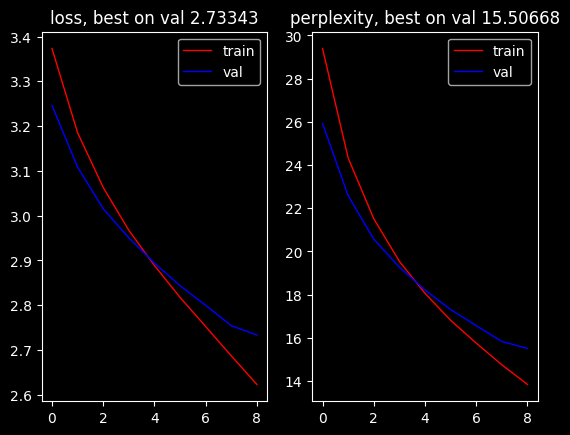

Language Model Linear с 2 GRU слоями


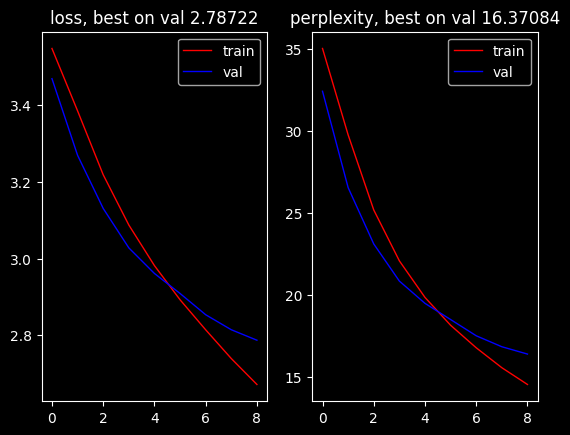

Language Model Linear с Bidirectional GRU слоем


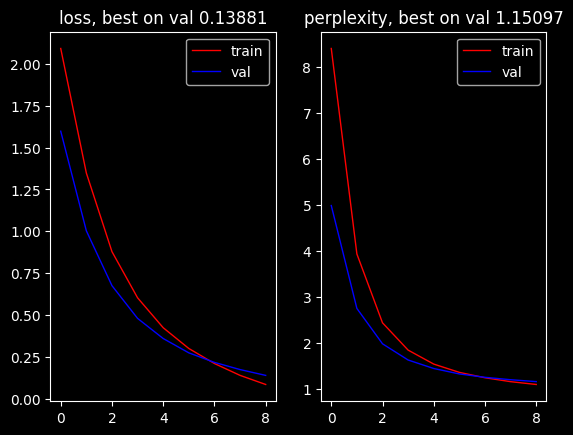

Language Model Linear с 2 Bidirectional GRU слоями


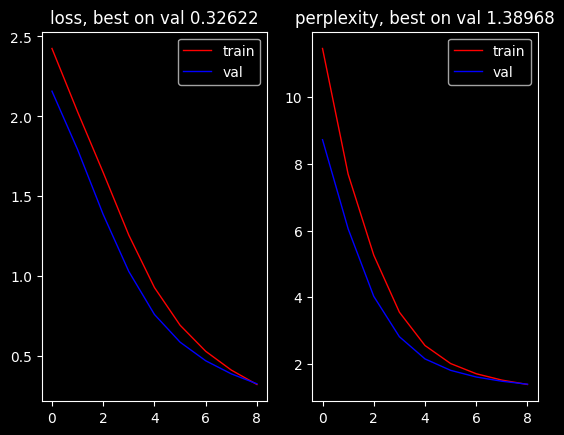

Language Model Conv Before GRU


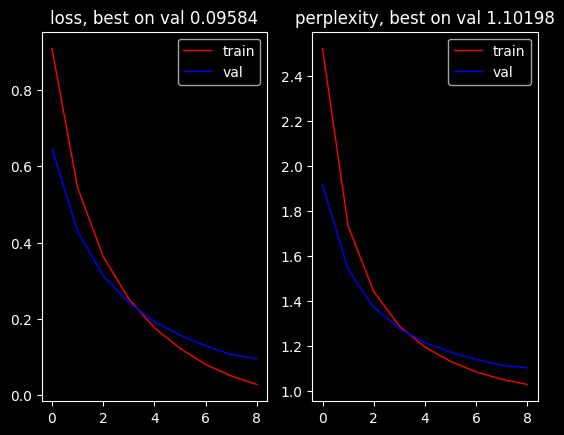

Language Model Conv Before GRU с батч нормализацией


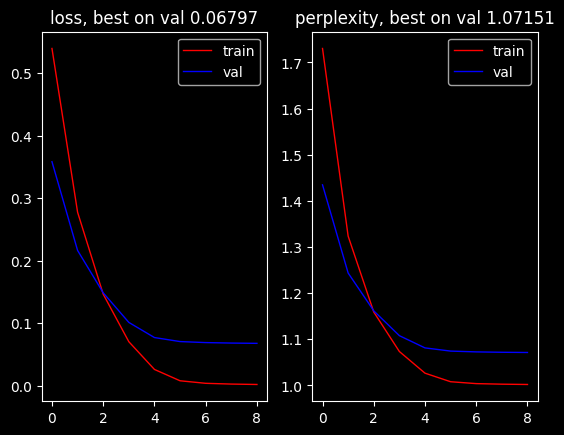

In [31]:
for history in all_histories:
    plot_result(history)

Сравним время выполнения алгоритмов

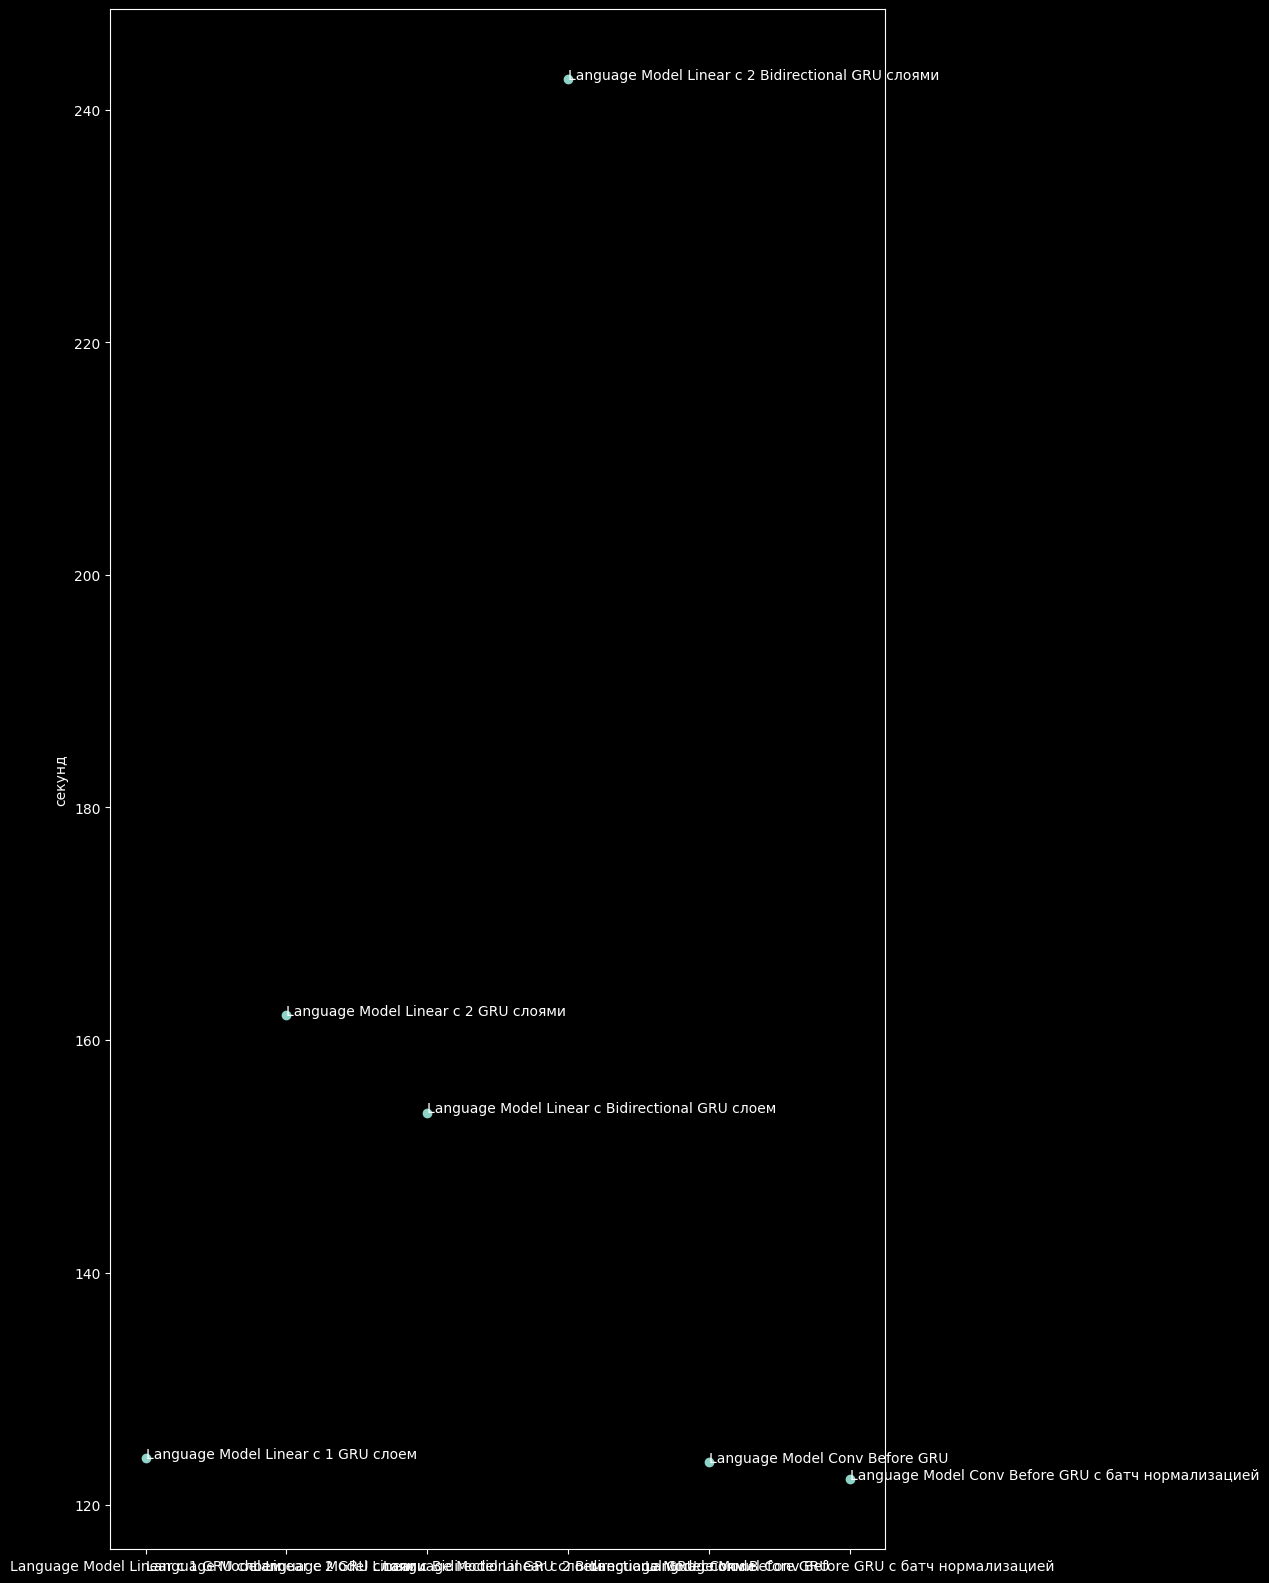

In [34]:
times = [(history['algo_desc'], history['execution_time']) for history in all_histories]

names, times = zip(*times)
plt.figure(figsize=(10, 20))
plt.scatter(names, times)

for name, time in zip(names, times):
    plt.annotate(name, (name, time))

plt.ylabel('секунд на эпоху')
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 

In [33]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 8) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
    
    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

generate_sequence(model, starting_seq='when you think ')

'<bos> when you think whom load anybody lives lover khan frogs moody'